In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy import stats

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data source:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged_covid.csv'
file_path3 = '/content/drive/My Drive/X999/bbl_cleaned.csv'
# file_path2 = '/content/drive/My Drive/X999/evictions_pre_post_covid.csv'

In [6]:
# evictions = pd.read_csv(file_path2)
bbl_cleaned = pd.read_csv(file_path3)

In [7]:
# list(bbl_cleaned.columns),
bbl_cleaned.shape
# so 753110 res buildings
# will use this number to calculate the average number of evictions per building, but not only the builingds that
# have the evictions, but all the res buildings

(753110, 112)

In [8]:
# evictions.eviction_count.sum()

In [9]:
bbl_evictions_merged_raw = pd.read_csv(file_path1)

In [10]:
bbl_evictions_merged = bbl_evictions_merged_raw.copy()

In [11]:
display(bbl_evictions_merged.head()), bbl_evictions_merged.shape

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade
0,35484/19,494073,184 MT. EDEN PARKWAY,UNIT 1D,2020-01-02,BRONX,10457,Not an Ejectment,Possession,40.842943,...,False,mid-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",21-100 units,True,large,Q4 (largest 25%),1920-1929
1,251388/19,117473,160 EAST 117 STREET,3-B,2020-01-02,MANHATTAN,10035,Not an Ejectment,Possession,40.799094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,66822/19,25733,66-07 ALDERTON ST,unknown,2020-01-02,QUEENS,11374,Not an Ejectment,Possession,40.719316,...,False,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",3-5 units,True,small,Q4 (largest 25%),1990-1999
3,68501/18,91505,1245 STRATFORD AVE,D12,2020-01-02,BRONX,10472,Not an Ejectment,Possession,40.830623,...,False,mid-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",21-100 units,True,very large,Q4 (largest 25%),1920-1929
4,68498/19,26147,28-16 47TH STREET,1-L,2020-01-02,QUEENS,11103,Not an Ejectment,Possession,40.762390,...,False,low-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",6-20 units,True,medium,Q4 (largest 25%),1920-1929


(None, (6338, 40))

In [12]:
type(bbl_evictions_merged.executed_date[0]), bbl_evictions_merged.executed_date[0]
bbl_evictions_merged['executed_date'] = pd.to_datetime(bbl_evictions_merged['executed_date'], format='%Y-%m-%d')
bbl_evictions_merged['executed_date'].dt.year.unique() # 5 years

array([2020, 2021, 2022], dtype=int32)

In [13]:
bbl_evictions_merged.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'bbl_clean', 'yearbuilt',
       'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea',
       'building_type', 'building_category', 'is_condo', 'floor_category',
       'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'is_llc', 'building_size_category',
       'size_quartile', 'decade'],
      dtype='object')

In [14]:
building_characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile', 'yearbuilt', 'numfloors', 'unitsres', 'decade'
]

In [15]:
nan_counts = bbl_evictions_merged[building_characteristics].isna().sum()
nan_percentages = (nan_counts / len(bbl_evictions_merged) * 100).round(3)
# percentage:.3f%

In [16]:
nan_counts, nan_percentages

(yearbuilt                     314
 bldgclass                     314
 numfloors                     314
 unitsres                      314
 ownername                     314
 bldgarea                      314
 building_type                 314
 building_category             314
 is_condo                      314
 floor_category                314
 rent_era                      314
 architectural_style           314
 economic_period               314
 residential_units_category    314
 is_llc                        314
 building_size_category        314
 size_quartile                 314
 yearbuilt                     314
 numfloors                     314
 unitsres                      314
 decade                        314
 dtype: int64,
 yearbuilt                     4.954
 bldgclass                     4.954
 numfloors                     4.954
 unitsres                      4.954
 ownername                     4.954
 bldgarea                      4.954
 building_type              

In [17]:
bbl_evictions_merged.shape

(6338, 40)

In [18]:
df = bbl_evictions_merged.copy()

In [19]:
df = bbl_evictions_merged.dropna(subset=['average_year_eviction_count'])

In [20]:
df.shape

(6338, 40)

In [21]:
df_clean = df.dropna(subset=building_characteristics)

In [22]:
df_clean.shape, 74082 - 70312
# good

((6024, 40), 3770)

In [23]:
df_clean['eviction_rate_per_unit'] = df_clean['average_year_eviction_count'] / df_clean['unitsres']
df_clean['eviction_rate_per_unit'] = df_clean['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
# second line handles potential division by zero errors

In [24]:
display(df_clean.head())

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,eviction_rate_per_unit
0,35484/19,494073,184 MT. EDEN PARKWAY,UNIT 1D,2020-01-02,BRONX,10457,Not an Ejectment,Possession,40.842943,...,mid-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",21-100 units,True,large,Q4 (largest 25%),1920-1929,0.038462
2,66822/19,25733,66-07 ALDERTON ST,unknown,2020-01-02,QUEENS,11374,Not an Ejectment,Possession,40.719316,...,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",3-5 units,True,small,Q4 (largest 25%),1990-1999,0.333333
3,68501/18,91505,1245 STRATFORD AVE,D12,2020-01-02,BRONX,10472,Not an Ejectment,Possession,40.830623,...,mid-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",21-100 units,True,very large,Q4 (largest 25%),1920-1929,0.013699
4,68498/19,26147,28-16 47TH STREET,1-L,2020-01-02,QUEENS,11103,Not an Ejectment,Possession,40.762390,...,low-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",6-20 units,True,medium,Q4 (largest 25%),1920-1929,0.166667
5,65335/19,11940,645 WEST 160TH STREET APT. 4C,4C,2020-01-02,MANHATTAN,10032,Not an Ejectment,Possession,40.836721,...,mid-rise,"Pre-1947, pre-rent-control","1900–1920, Beaux-Arts","Pre-1929, pre-great depression",21-100 units,True,very large,Q4 (largest 25%),1910-1919,0.020833


In [25]:
building_evictions = df.groupby('bbl_clean').agg({
    'average_year_eviction_count': 'mean',
    'eviction_count': 'sum',
    'unitsres': 'first',
    'decade': 'first',
    'building_category': 'first',
    'building_type': 'first',
    'is_llc': 'first',
    'yearbuilt': 'first',
    'bldgclass': 'first',
    'numfloors': 'first',
    'bldgarea': 'first',
    'is_condo': 'first',
    'floor_category': 'first',
    'rent_era': 'first',
    'architectural_style': 'first',
    'economic_period': 'first',
    'residential_units_category': 'first',
    'building_size_category': 'first',
    'size_quartile': 'first'
}).reset_index()
building_evictions['eviction_rate_per_unit'] = building_evictions['average_year_eviction_count'] / building_evictions['unitsres']

In [26]:
characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile'
]
characteristics = list(dict.fromkeys(characteristics))
building_evictions['eviction_rate_per_unit'] = building_evictions['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
building_evictions_clean = building_evictions.dropna(subset=['eviction_rate_per_unit'])
current_year = pd.Timestamp.now().year
building_evictions_clean['building_age'] = current_year - building_evictions_clean['yearbuilt']
characteristics.append('building_age')

In [27]:
current_year = pd.Timestamp.now().year
bbl_cleaned['building_age'] = current_year - bbl_cleaned['yearbuilt']

In [28]:
print(f"total buildings analyzed: {len(building_evictions_clean)}")
print(f"average eviction rate per unit: {building_evictions_clean['eviction_rate_per_unit'].mean():.4f}")

total buildings analyzed: 4753
average eviction rate per unit: 0.2431


In [29]:
numerical_chars = building_evictions_clean[characteristics].select_dtypes(include=[np.number]).columns.tolist()
numerical_chars

['yearbuilt', 'numfloors', 'unitsres', 'bldgarea', 'building_age']

In [30]:
"building_age" in bbl_cleaned.columns, "building_age" in building_evictions_clean.columns

(True, True)

In [31]:
"bbl_cleaned" in bbl_cleaned.columns

False

In [32]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'decade', 'building_category', 'building_type', 'is_llc',
       'yearbuilt', 'bldgclass', 'numfloors', 'bldgarea', 'is_condo',
       'floor_category', 'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age'],
      dtype='object')

In [33]:
print(bbl_cleaned.columns.tolist())
print(building_evictions_clean.columns.tolist())

['borough', 'block', 'lot', 'community board', 'census tract 2010', 'cb2010', 'schooldist', 'council district', 'postcode', 'firecomp', 'policeprct', 'healtharea', 'sanitboro', 'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl', 'condono', 'tract2010', 'xcoord', 'ycoord', 'latitude', 'longitude', 'zonemap', 'zmcode', 'sanborn', 'taxmap', 'edesignum', 'appbbl',

In [34]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'decade', 'building_category', 'building_type', 'is_llc',
       'yearbuilt', 'bldgclass', 'numfloors', 'bldgarea', 'is_condo',
       'floor_category', 'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age'],
      dtype='object')

In [35]:
building_evictions_clean['evictions_per_unit'] = building_evictions_clean['average_year_eviction_count'] / building_evictions_clean['unitsres']
building_evictions_clean['evictions_per_100_units'] = (building_evictions_clean['average_year_eviction_count'] / building_evictions_clean['unitsres']) * 100

In [36]:
display(building_evictions_clean.head(5))

,bbl_clean,average_year_eviction_count,eviction_count,unitsres,decade,building_category,building_type,is_llc,yearbuilt,bldgclass,...,rent_era,architectural_style,economic_period,residential_units_category,building_size_category,size_quartile,eviction_rate_per_unit,building_age,evictions_per_unit,evictions_per_100_units
0,1000160015,1.0,2,208.0,1990-1999,elevator,post-war,False,1998.0,D8,...,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",100+ units,mega,Q4 (largest 25%),0.004808,27.0,0.004808,0.480769
1,1000160100,3.0,90,1712.0,1980-1989,elevator,post-war,False,1983.0,D6,...,"1970–1993, deregularization","1981–2000, Post-Modernism","1976–1990, fiscal crisis and recovery",100+ units,mega,Q4 (largest 25%),0.001752,42.0,0.001752,0.175234
4,1000170029,1.0,20,397.0,1960-1969,elevator,post-war,True,1969.0,D5,...,"1947–1969, rent-control","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,mega,Q4 (largest 25%),0.002519,56.0,0.002519,0.251889
6,1000210006,1.0,3,237.0,Pre-1900,elevator,pre-war,False,1898.0,D5,...,"Pre-1947, pre-rent-control",Pre-1900,"Pre-1929, pre-great depression",100+ units,mega,Q4 (largest 25%),0.004219,127.0,0.004219,0.421941
7,1000260021,1.0,2,435.0,1950-1959,elevator,post-war,False,1958.0,D9,...,"1947–1969, rent-control","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,mega,Q4 (largest 25%),0.002299,67.0,0.002299,0.229885


In [37]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'decade', 'building_category', 'building_type', 'is_llc',
       'yearbuilt', 'bldgclass', 'numfloors', 'bldgarea', 'is_condo',
       'floor_category', 'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age', 'evictions_per_unit',
       'evictions_per_100_units'],
      dtype='object')

In [38]:
corr = building_evictions_clean['building_age'].corr(building_evictions_clean['average_year_eviction_count'], method='pearson')
corr

np.float64(0.025098138117636466)

## Categorical analysis:

### Consolidated Functions:

In [39]:
def build_category_dataframes(bbl_cleaned, cleaned_dataframe, category_column, num_years=5):
    category_data = cleaned_dataframe.groupby(category_column).agg(
        total_evictions=('eviction_count', 'count')
    ).reset_index()
    total_evictions = category_data['total_evictions'].sum()
    category_data['eviction_percentage'] = category_data['total_evictions'] / total_evictions
    total_building_count = 753110

    building_counts = bbl_cleaned['bbl'].groupby(bbl_cleaned[category_column]).nunique()
    building_counts_df = bbl_cleaned.groupby(category_column)['bbl'].nunique().reset_index()
    building_counts_df.columns = [category_column, 'building_count']
    total_buildings = building_counts_df.building_count.sum()
    building_counts_df['building_percentage'] = (building_counts_df['building_count'] / total_buildings) * 100

    category_data = pd.merge(category_data, building_counts_df, on=category_column)
    num_years = 5  # outside of covid
    category_data['yearly_evictions_per_cat'] = category_data['total_evictions'] / num_years
    evictions_per_100_by_category = cleaned_dataframe.groupby(category_column)['evictions_per_100_units'].mean().reset_index()
    category_data = pd.merge(category_data, evictions_per_100_by_category, on=category_column)
    category_data['yearly_evictions_per_100unit'] = category_data['evictions_per_100_units'] / num_years


    return category_data

In [40]:
def create_bar_chart(category_data,category_name, rate, title, xlabel, ylabel, figsize=(7, 7),
                     percentage_column=None, rotation=45, add_value_labels=True):
    plt.figure(figsize=figsize)
    bars = plt.bar(category_data[category_name], category_data[ rate])
    if add_value_labels:
        for i, value in enumerate(category_data[rate]):
            label_text = f"{value:.2f}" if value < 100 else f"{value:,.2f}"

            if percentage_column is not None:
                percentage = category_data[percentage_column].iloc[i]
                label_text += f"\n({percentage:.1f}%)"

            offset = value * 0.01 if value < 100 else value * 0.0001
            plt.text(i, value + offset, label_text, ha='center', fontsize=9)

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=rotation, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### 2. Building Type: Pre/Post-war

In [41]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'building_type')
category_data

,building_type,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,post-war,1499,0.31538,290789,38.611757,299.8,24.427132,4.885426
1,pre-war,3254,0.68462,462321,61.388243,650.8,24.250682,4.850136


In [42]:
total_yearly_evictions = category_data['total_evictions']
category_data['percentage'] = category_data['eviction_percentage']* 100

In [43]:
category_data['percentage']

,percentage
0,31.537976
1,68.462024


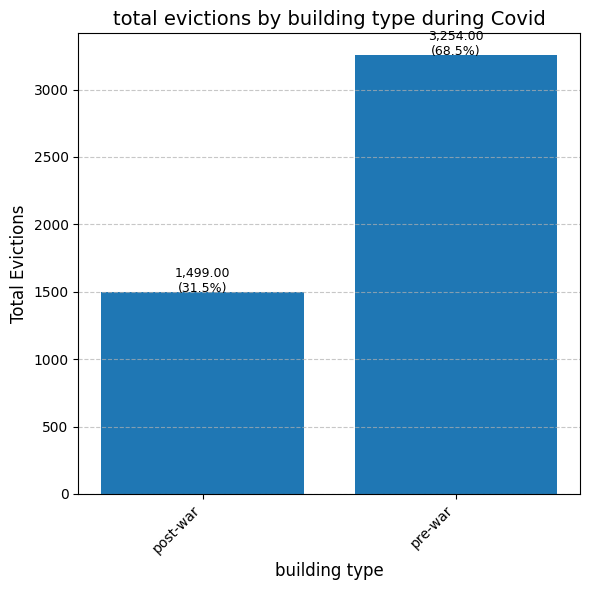

In [44]:
create_bar_chart(
    category_data,
    category_name ='building_type',
    rate ='total_evictions',
    figsize=(6, 6),
    title='total evictions by building type during Covid',
    xlabel='building type',
    ylabel='Total Evictions',
    percentage_column='percentage'
)

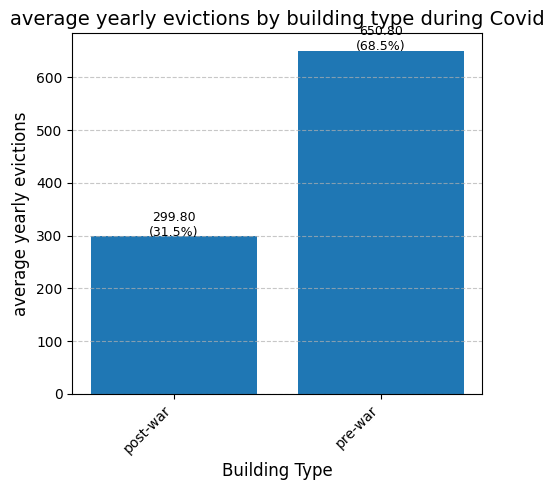

In [45]:
create_bar_chart(
    category_data,
    figsize=(5, 5),
    category_name ='building_type',
    rate ='yearly_evictions_per_cat',
    title='average yearly evictions by building type during Covid',
    xlabel='Building Type',
    ylabel='average yearly evictions',
    percentage_column='percentage'
)

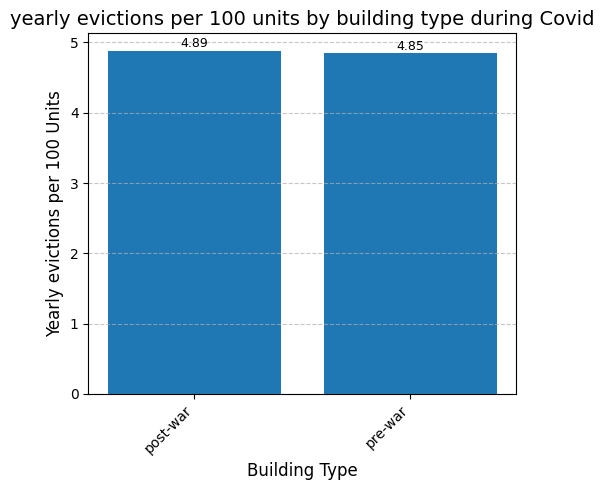

In [46]:
create_bar_chart(
    category_data,
    figsize=(5, 5),
    category_name ='building_type',
    rate ='yearly_evictions_per_100unit',
    title='yearly evictions per 100 units by building type during Covid',
    xlabel='Building Type',
    ylabel='Yearly evictions per 100 Units',
    percentage_column=None
)

In [47]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['building_type']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. post-war: 4.8854
2. pre-war: 4.8501


During covid, pre-war and post-war buildings experinced similar amount of evictions. Different from normal times, pre-war buildings tended to observe 18% more evictions than post-war buildings. (per building, per year, per unit)

## 2. Architectural Styles

In [48]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'architectural_style')
# category_data

In [49]:
order = ['Pre-1900', '1900–1920, Beaux-Arts', '1921–1930, Art Deco Skyscrapers',
         '1931–1950, Manhattan Modern', '1951–1980, the International Style, Alternative Modernism',
         '1981–2000, Post-Modernism', '2001-present, New Architecture']
category_data['architectural_style'] = pd.Categorical(category_data['architectural_style'], categories=order, ordered=True)
category_data = category_data.sort_values('architectural_style')

In [50]:
total_yearly_evictions = category_data['total_evictions']
category_data['percentage'] = category_data['eviction_percentage']* 100

In [51]:
category_data

,architectural_style,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit,percentage
6,Pre-1900,136,0.028614,38089,5.057561,27.2,48.778830,9.755766,2.861351
0,"1900–1920, Beaux-Arts",1212,0.254997,182991,24.298044,242.4,29.074460,5.814892,25.499684
1,"1921–1930, Art Deco Skyscrapers",1310,0.275615,153977,20.445486,262.0,19.530747,3.906149,27.561540
2,"1931–1950, Manhattan Modern",771,0.162213,157454,20.907172,154.2,23.782466,4.756493,16.221334
3,"1951–1980, the International Style, Alternativ...",745,0.156743,122280,16.236672,149.0,18.360126,3.672025,15.674311
4,"1981–2000, Post-Modernism",158,0.033242,49603,6.586422,31.6,29.858759,5.971752,3.324216
5,"2001-present, New Architecture",421,0.088576,48716,6.468643,84.2,26.931796,5.386359,8.857564


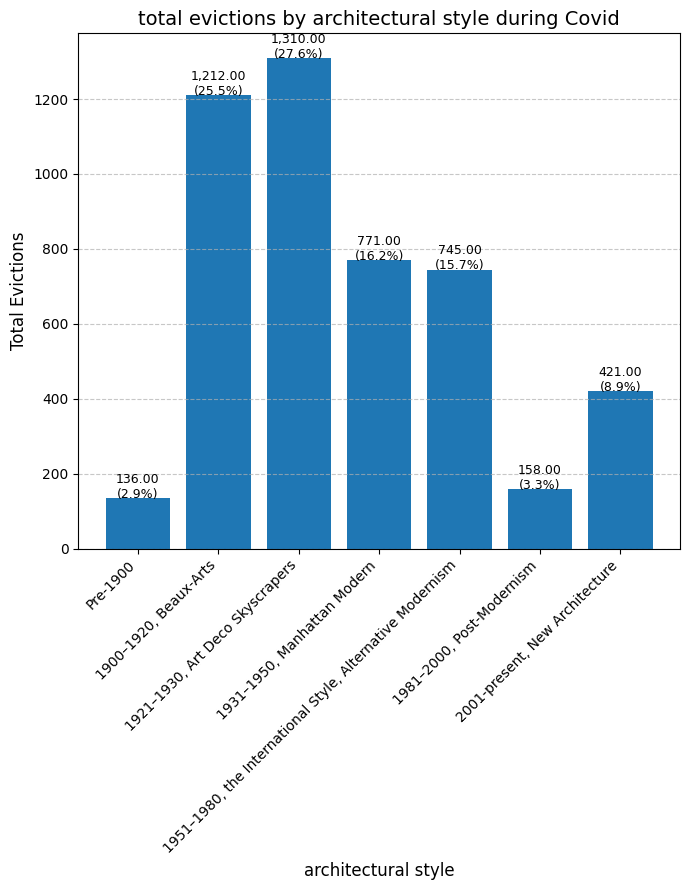

In [52]:
create_bar_chart(
    category_data,
    category_name ='architectural_style',
    rate ='total_evictions',
    figsize=(7, 9),
    title='total evictions by architectural style during Covid',
    xlabel='architectural style',
    ylabel='Total Evictions',
    percentage_column='percentage'
)

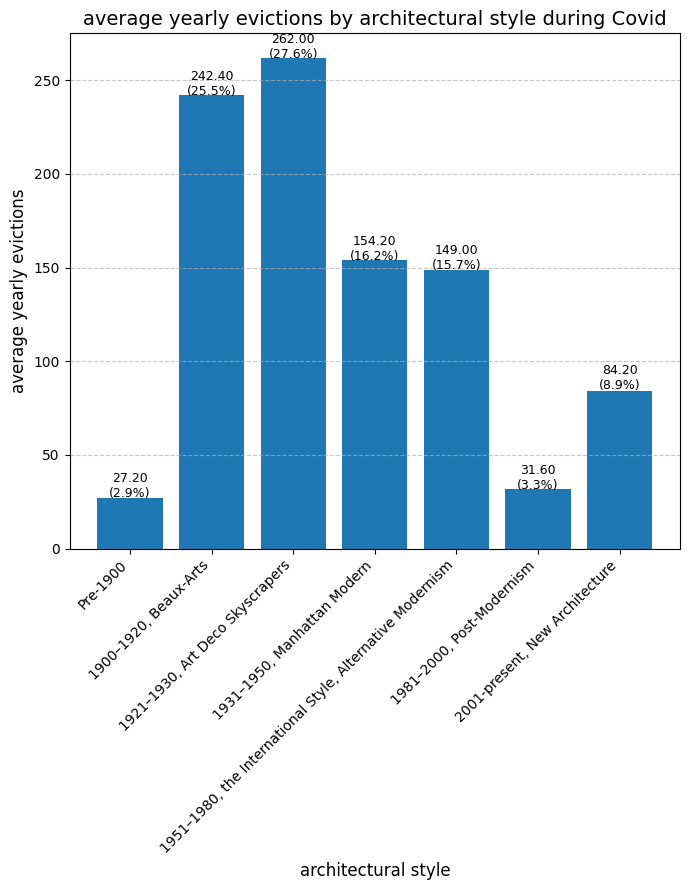

In [53]:
create_bar_chart(
    category_data,
    figsize=(7, 9),
    category_name ='architectural_style',
    rate ='yearly_evictions_per_cat',
    title='average yearly evictions by architectural style during Covid',
    xlabel='architectural style',
    ylabel='average yearly evictions',
    percentage_column='percentage'
)

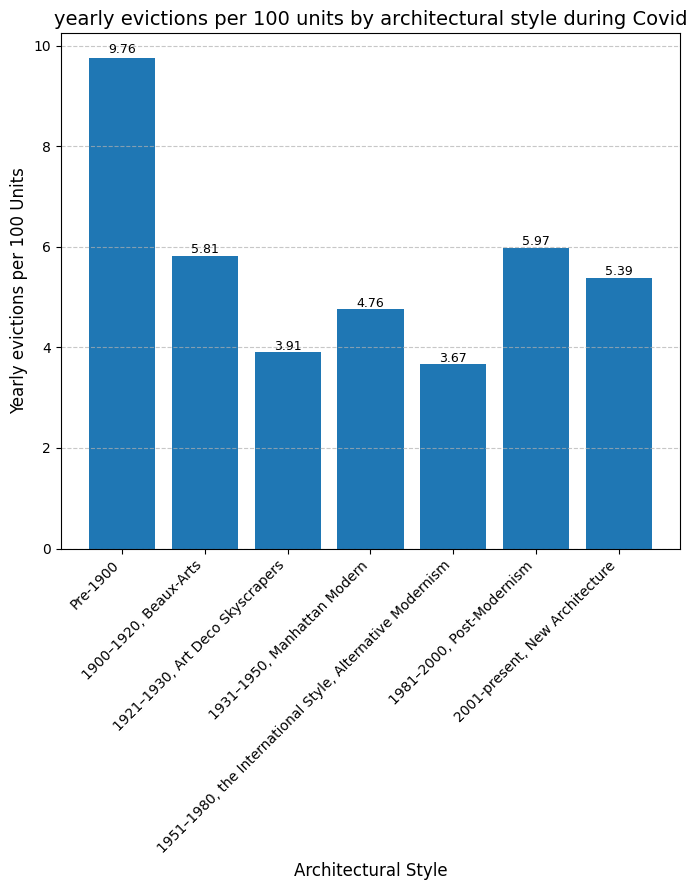

In [54]:
create_bar_chart(
    category_data,
    figsize=(7, 9),
    category_name ='architectural_style',
    rate ='yearly_evictions_per_100unit',
    title='yearly evictions per 100 units by architectural style during Covid',
    xlabel='Architectural Style',
    ylabel='Yearly evictions per 100 Units',
    percentage_column=None
)

In [55]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['architectural_style']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. Pre-1900: 9.7558
2. 1981–2000, Post-Modernism: 5.9718
3. 1900–1920, Beaux-Arts: 5.8149
4. 2001-present, New Architecture: 5.3864
5. 1931–1950, Manhattan Modern: 4.7565
6. 1921–1930, Art Deco Skyscrapers: 3.9061
7. 1951–1980, the International Style, Alternative Modernism: 3.6720


Similar results to normal times.

### Since architectural stypes are closely related to the age of the buildings, we will take a closer look at the age of the building.

In [56]:
building_evictions_clean.building_age.unique()

array([  27.,   42.,   56.,  127.,   67.,   96.,  104.,   53.,   94.,
         52.,   75.,   50.,   95.,  110.,  125.,   63.,  105.,  115.,
         65.,  100.,  113.,   28.,   25.,   22.,   17.,   32.,   54.,
         61.,  150.,  128.,   97.,  162.,  132.,  139.,  120.,  118.,
        124.,  121.,  126.,  122.,   85.,   31.,  117.,  181.,   64.,
        137.,   99.,   10.,   18.,   62.,  185.,   23.,   87.,   66.,
         98.,  123.,   45.,   48.,   60.,   57.,   55.,   46.,   40.,
         11.,   78.,   24.,   36.,   38.,  101.,  111.,  135.,   83.,
        114.,   51.,   49.,   86.,   29.,    9.,   44.,   26.,   20.,
        109.,  130.,  138.,  106.,  103.,   77.,  108.,  129.,  112.,
         58.,  136.,   91.,   88.,   89., 2025.,   90.,  116.,   79.,
         39.,   69.,   59.,   71.,   43.,   15.,   37.,   68.,   19.,
        140.,   70.,  119.,   16.,   21.,  102.,   12.,   74.,   93.,
          8.,  143.,    7.,   34.,   13.,   14.,  107.,   84.,   76.,
        175.,   33.,

In [57]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'decade', 'building_category', 'building_type', 'is_llc',
       'yearbuilt', 'bldgclass', 'numfloors', 'bldgarea', 'is_condo',
       'floor_category', 'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age', 'evictions_per_unit',
       'evictions_per_100_units'],
      dtype='object')

### 3. By Decades

In [58]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'decade')
category_data

,decade,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,1900-1909,320,0.067326,39141,5.197497,64.0,27.053555,5.410711
1,1910-1919,545,0.114664,59065,7.843187,109.0,22.495362,4.499072
2,1920-1929,1331,0.280034,168261,22.343223,266.2,20.399428,4.079886
3,1930-1939,808,0.169998,119817,15.910389,161.6,25.819997,5.163999
4,1940-1949,185,0.038923,63636,8.450166,37.0,31.481661,6.296332
5,1950-1959,309,0.065012,73472,9.756279,61.8,25.536855,5.107371
6,1960-1969,348,0.073217,57993,7.700837,69.6,17.041526,3.408305
7,1970-1979,176,0.037029,30151,4.003723,35.2,19.917566,3.983513
8,1980-1989,84,0.017673,24597,3.266213,16.8,31.286227,6.257245
9,1990-1999,71,0.014938,26336,3.497133,14.2,31.718508,6.343702


In [59]:
order = ['Pre-1900', '1900-1909', '1910-1919', '1920-1929', '1930-1939', '1940-1949',
       '1950-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999',
       '2000-2009', '2010-2019']
category_data['decade'] = pd.Categorical(category_data['decade'], categories= order, ordered=True)
category_data = category_data.sort_values('decade')

In [60]:
total_yearly_evictions = category_data['total_evictions']
category_data['percentage'] = category_data['eviction_percentage']* 100

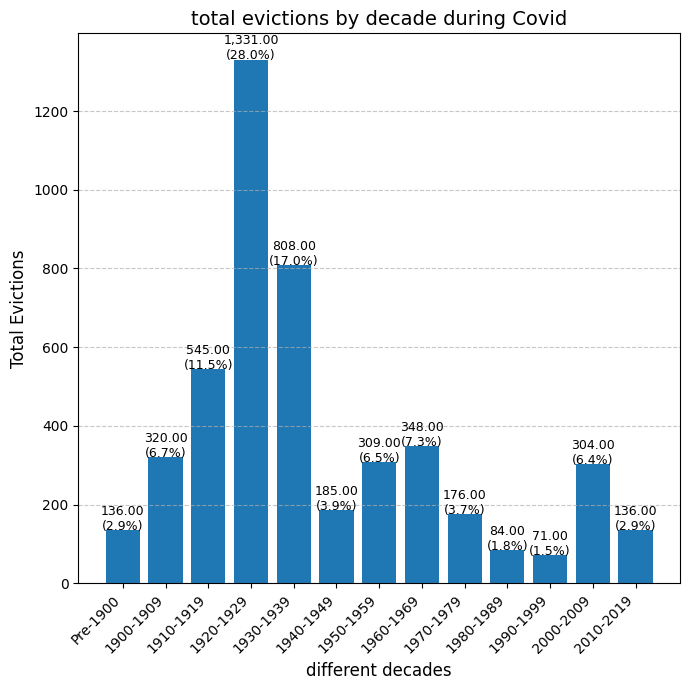

In [61]:
create_bar_chart(
    category_data,
    category_name ='decade',
    rate ='total_evictions',
    title='total evictions by decade during Covid',
    xlabel='different decades',
    ylabel='Total Evictions',
    percentage_column='percentage'
)

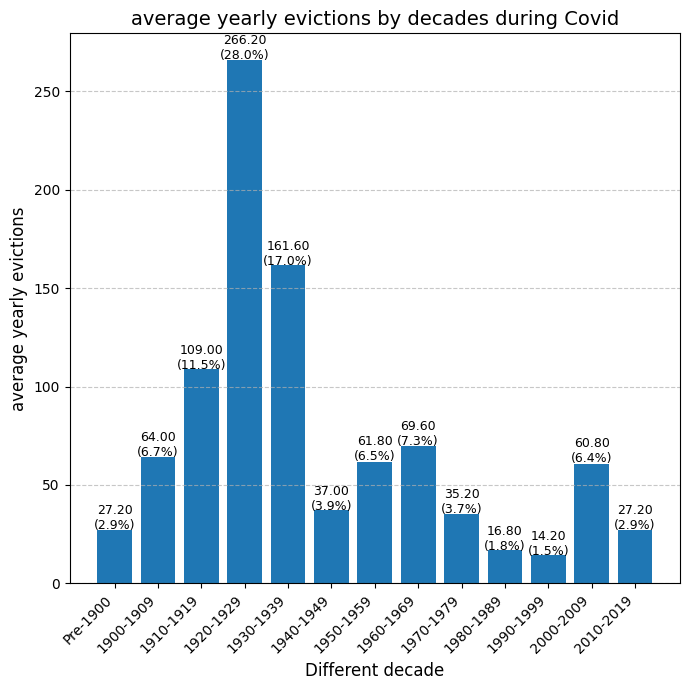

In [62]:
create_bar_chart(
    category_data,
    category_name ='decade',
    rate ='yearly_evictions_per_cat',
    title='average yearly evictions by decades during Covid',
    xlabel='Different decade',
    ylabel='average yearly evictions',
    percentage_column='percentage'
)

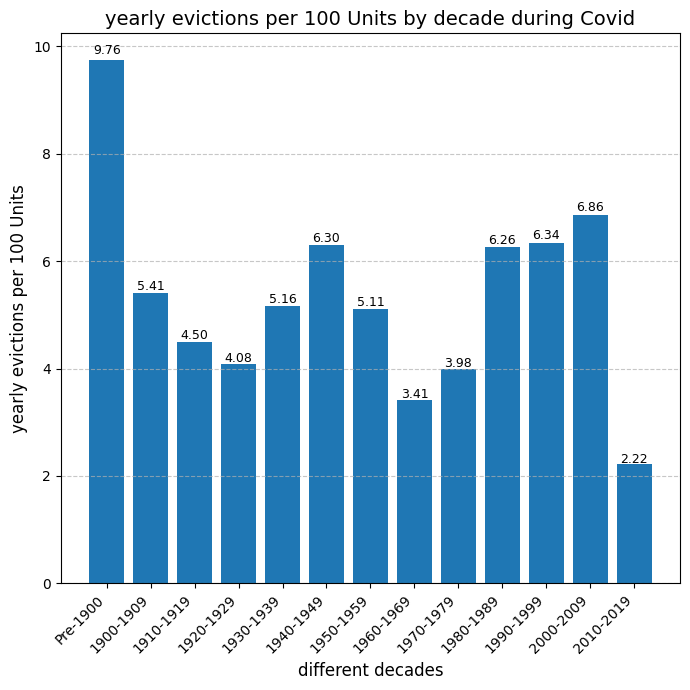

In [63]:
create_bar_chart(
    category_data,
    category_name ='decade',
    rate ='yearly_evictions_per_100unit',
    title='yearly evictions per 100 Units by decade during Covid',
    xlabel='different decades',
    ylabel='yearly evictions per 100 Units',
    percentage_column=None
)

In [64]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['decade']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. Pre-1900: 9.7558
2. 2000-2009: 6.8579
3. 1990-1999: 6.3437
4. 1940-1949: 6.2963
5. 1980-1989: 6.2572
6. 1900-1909: 5.4107
7. 1930-1939: 5.1640
8. 1950-1959: 5.1074
9. 1910-1919: 4.4991
10. 1920-1929: 4.0799
11. 1970-1979: 3.9835
12. 1960-1969: 3.4083
13. 2010-2019: 2.2174


No strong linear relationship with the age of the buildings and eviction rates. Similar to normal times

## 5. Floor Category

In [65]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'floor_category')
category_data

,floor_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,high-rise,566,0.119083,7194,0.955239,113.2,1.172736,0.234547
1,low-rise,1943,0.408794,695209,92.311747,388.6,54.198447,10.839689
2,mid-rise,2244,0.472123,50707,6.733014,448.8,4.258753,0.851751


In [66]:
order = ['low-rise', 'mid-rise', 'high-rise']
category_data['floor_category'] = pd.Categorical(category_data['floor_category'], categories= order, ordered=True)
category_data = category_data.sort_values('floor_category')

In [67]:
total_yearly_evictions = category_data['total_evictions']
category_data['percentage'] = category_data['eviction_percentage']* 100

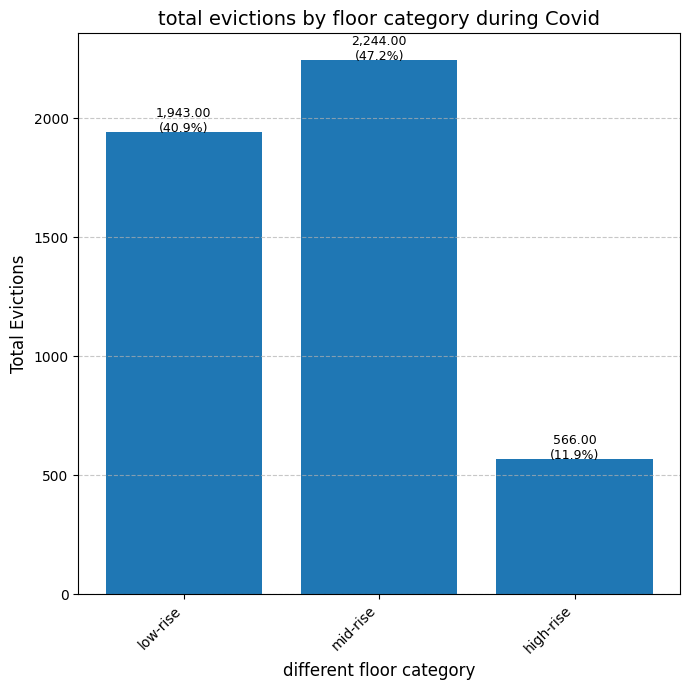

In [68]:
create_bar_chart(
    category_data,
    category_name ='floor_category',
    rate ='total_evictions',
    title='total evictions by floor category during Covid',
    xlabel='different floor category',
    ylabel='Total Evictions',
    percentage_column='percentage'
)

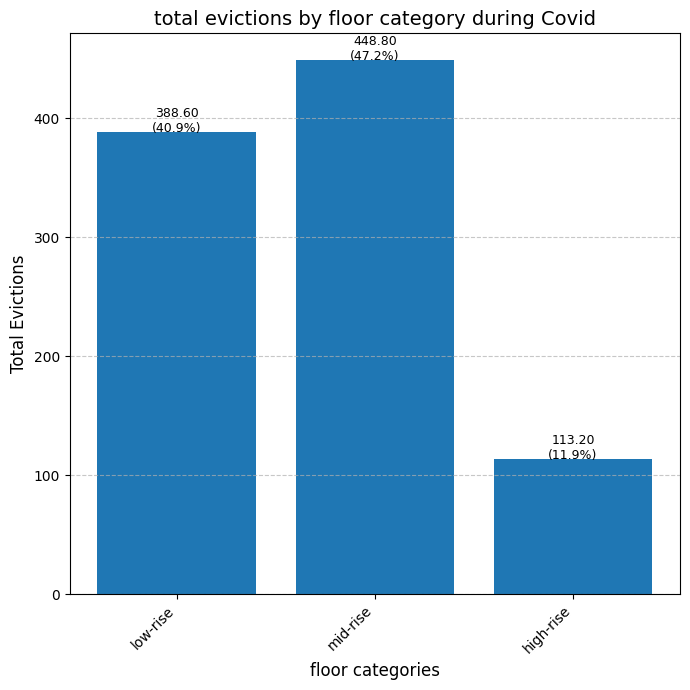

In [69]:
create_bar_chart(
    category_data,
    category_name ='floor_category',
    rate ='yearly_evictions_per_cat',
    title='total evictions by floor category during Covid',
    xlabel='floor categories',
    ylabel='Total Evictions',
    percentage_column='percentage'
)

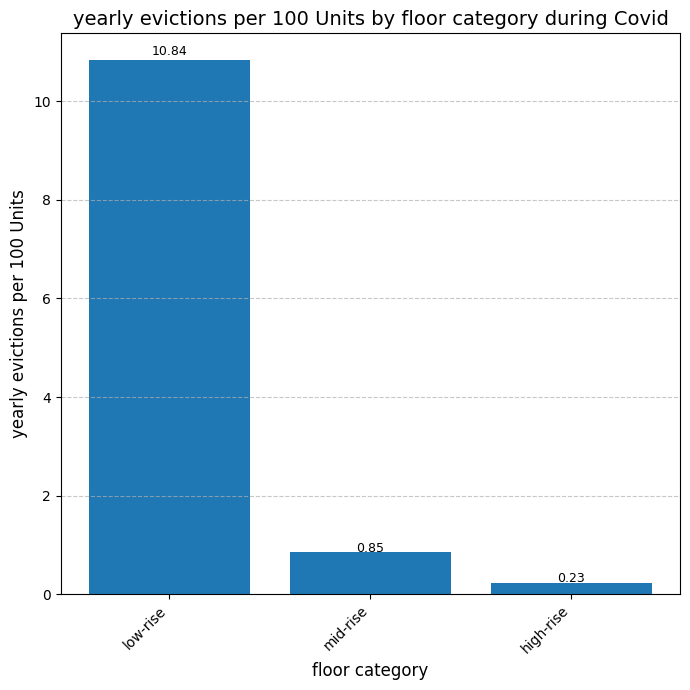

In [70]:
create_bar_chart(
    category_data,
    category_name ='floor_category',
    rate ='yearly_evictions_per_100unit',
    title='yearly evictions per 100 Units by floor category during Covid',
    xlabel='floor category',
    ylabel='yearly evictions per 100 Units',
    percentage_column=None
)

In [71]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['floor_category']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. low-rise: 10.8397
2. mid-rise: 0.8518
3. high-rise: 0.2345


Makes sense, with the previous numerical correlation test. Similiar to normal times, too.

## 6.Residential Units Category

In [72]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'residential_units_category')
category_data.residential_units_category.unique()

array(['100+ units', '2-unit', '21-100 units', '3-5 units', '6-20 units',
       'single-unit'], dtype=object)

In [73]:
category_data

,residential_units_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,100+ units,693,0.145803,3445,0.457436,138.6,0.619315,0.123863
1,2-unit,809,0.170208,266988,35.451395,161.8,60.970334,12.194067
2,21-100 units,1675,0.352409,18111,2.404828,335.0,2.612784,0.522557
3,3-5 units,614,0.129182,103859,13.790681,122.8,35.675896,7.135179
4,6-20 units,695,0.146223,40058,5.319011,139.0,11.212077,2.242415
5,single-unit,267,0.056175,320649,42.576649,53.4,118.726592,23.745318


In [74]:
order = ['single-unit', '2-unit', '3-5 units', '6-20 units', '21-100 units', '100+ units']
category_data['residential_units_category'] = pd.Categorical(category_data['residential_units_category'], categories= order, ordered=True)
category_data = category_data.sort_values('residential_units_category')

In [75]:
category_data

,residential_units_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
5,single-unit,267,0.056175,320649,42.576649,53.4,118.726592,23.745318
1,2-unit,809,0.170208,266988,35.451395,161.8,60.970334,12.194067
3,3-5 units,614,0.129182,103859,13.790681,122.8,35.675896,7.135179
4,6-20 units,695,0.146223,40058,5.319011,139.0,11.212077,2.242415
2,21-100 units,1675,0.352409,18111,2.404828,335.0,2.612784,0.522557
0,100+ units,693,0.145803,3445,0.457436,138.6,0.619315,0.123863


In [76]:
total_yearly_evictions = category_data['total_evictions']
category_data['percentage'] = category_data['eviction_percentage']* 100

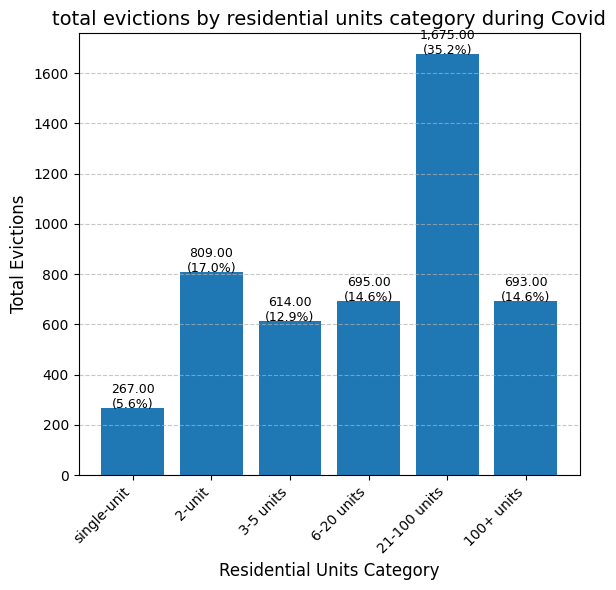

In [77]:
create_bar_chart(
    category_data,
    category_name ='residential_units_category',
    rate ='total_evictions',
    figsize=(6, 6),
    title='total evictions by residential units category during Covid',
    xlabel='Residential Units Category',
    ylabel='Total Evictions',
    percentage_column='percentage'
)

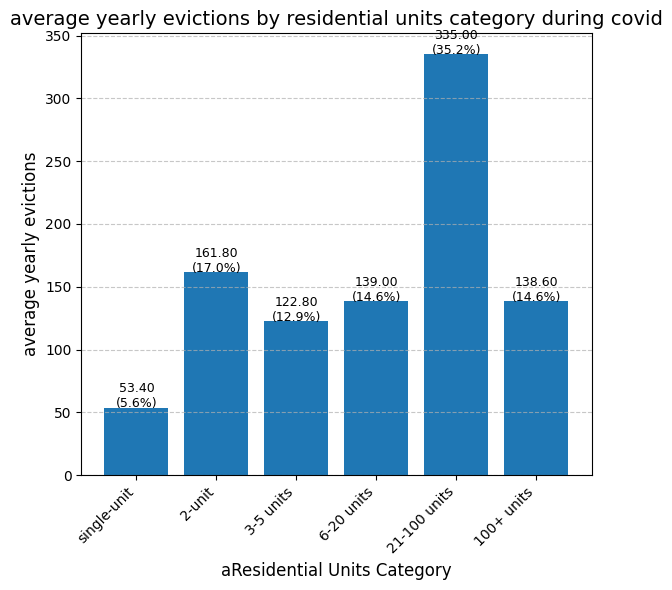

In [78]:
create_bar_chart(
    category_data,
    figsize=(6, 6),
    category_name ='residential_units_category',
    rate ='yearly_evictions_per_cat',
    title='average yearly evictions by residential units category during covid',
    xlabel='aResidential Units Category',
    ylabel='average yearly evictions',
    percentage_column='percentage'
)

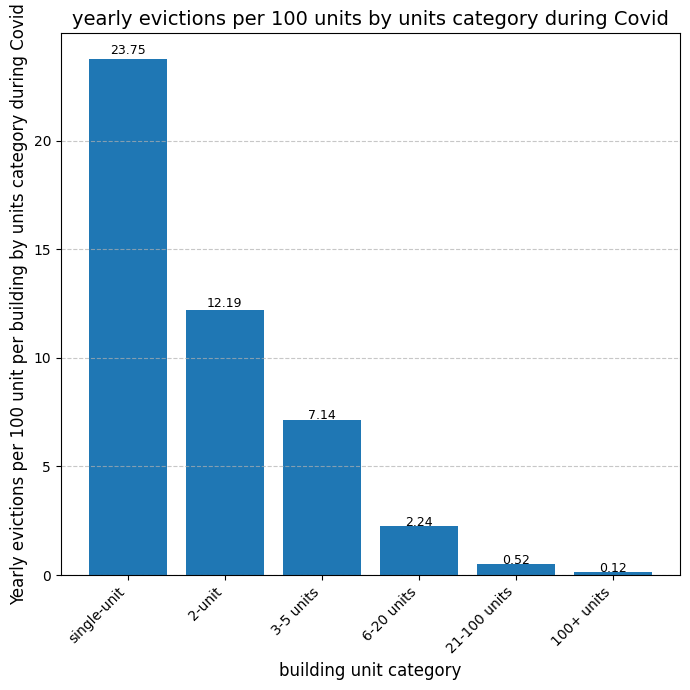

In [79]:
create_bar_chart(
    category_data,
    figsize=(7, 7),
    category_name ='residential_units_category',
    rate ='yearly_evictions_per_100unit',
    title='yearly evictions per 100 units by units category during Covid',
    xlabel='building unit category',
    ylabel='Yearly evictions per 100 unit per building by units category during Covid',
    percentage_column=None
)

In [80]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['residential_units_category']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. single-unit: 23.7453
2. 2-unit: 12.1941
3. 3-5 units: 7.1352
4. 6-20 units: 2.2424
5. 21-100 units: 0.5226
6. 100+ units: 0.1239


There is a strong inverse relationship between the number of units in a building and the eviction rate per unit in a building. \
Further analysis combined with building size category, see below.\
Similar to normal times.

## 7. Building Size Category

In [81]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'building_size_category')
category_data.building_size_category.unique()

array(['large', 'medium', 'medium-small', 'mega', 'small', 'tiny',
       'very large', 'very small'], dtype=object)

In [82]:
category_data

,building_size_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,large,566,0.119083,14761,1.960006,113.2,5.593844,1.118769
1,medium,372,0.078266,31069,4.125427,74.4,14.825166,2.965033
2,medium-small,507,0.106669,105397,13.994901,101.4,37.858041,7.571608
3,mega,680,0.143068,3740,0.496607,136.0,0.640440,0.128088
4,small,647,0.136125,206682,27.443800,129.4,55.676265,11.135253
5,tiny,45,0.009468,29398,3.903547,9.0,106.666667,21.333333
6,very large,1383,0.290974,13011,1.727636,276.6,2.235768,0.447154
7,very small,553,0.116348,349052,46.348077,110.6,78.305204,15.661041


In [83]:
order = ['tiny', 'very small', 'small','medium-small', 'medium','large', 'very large','mega']
category_data['building_size_category'] = pd.Categorical(category_data['building_size_category'], categories= order, ordered=True)
category_data = category_data.sort_values('building_size_category')

In [84]:
category_data

,building_size_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
5,tiny,45,0.009468,29398,3.903547,9.0,106.666667,21.333333
7,very small,553,0.116348,349052,46.348077,110.6,78.305204,15.661041
4,small,647,0.136125,206682,27.443800,129.4,55.676265,11.135253
2,medium-small,507,0.106669,105397,13.994901,101.4,37.858041,7.571608
1,medium,372,0.078266,31069,4.125427,74.4,14.825166,2.965033
0,large,566,0.119083,14761,1.960006,113.2,5.593844,1.118769
6,very large,1383,0.290974,13011,1.727636,276.6,2.235768,0.447154
3,mega,680,0.143068,3740,0.496607,136.0,0.640440,0.128088


In [85]:
total_yearly_evictions = category_data['total_evictions']
category_data['percentage'] = category_data['eviction_percentage']* 100

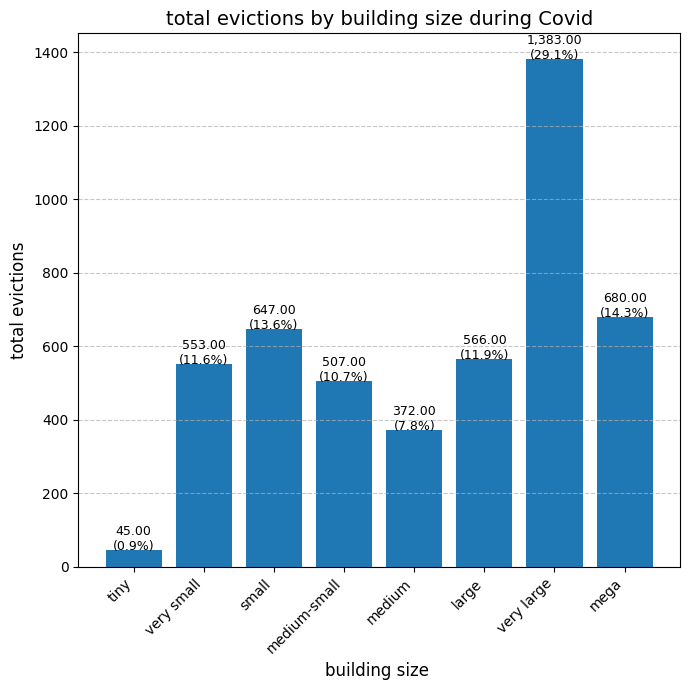

In [86]:
create_bar_chart(
    category_data,
    category_name ='building_size_category',
    rate ='total_evictions',
    figsize=(7, 7),
    title='total evictions by building size during Covid',
    xlabel='building size ',
    ylabel='total evictions',
    percentage_column='percentage'
)

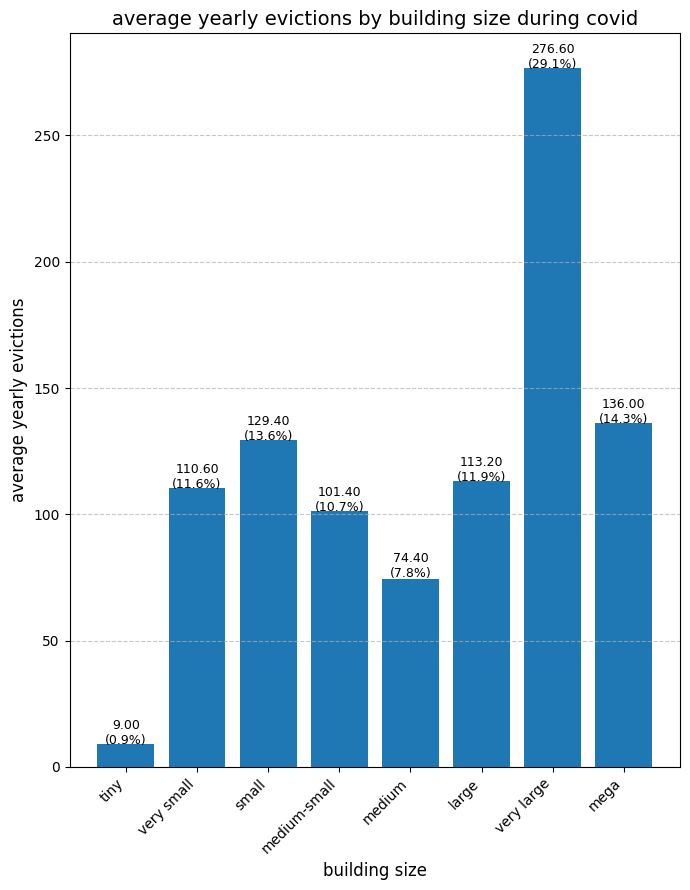

In [87]:
create_bar_chart(
    category_data,
    figsize=(7, 9),
    category_name ='building_size_category',
    rate ='yearly_evictions_per_cat',
    title='average yearly evictions by building size during covid',
    xlabel='building size',
    ylabel='average yearly evictions',
    percentage_column='percentage'
)

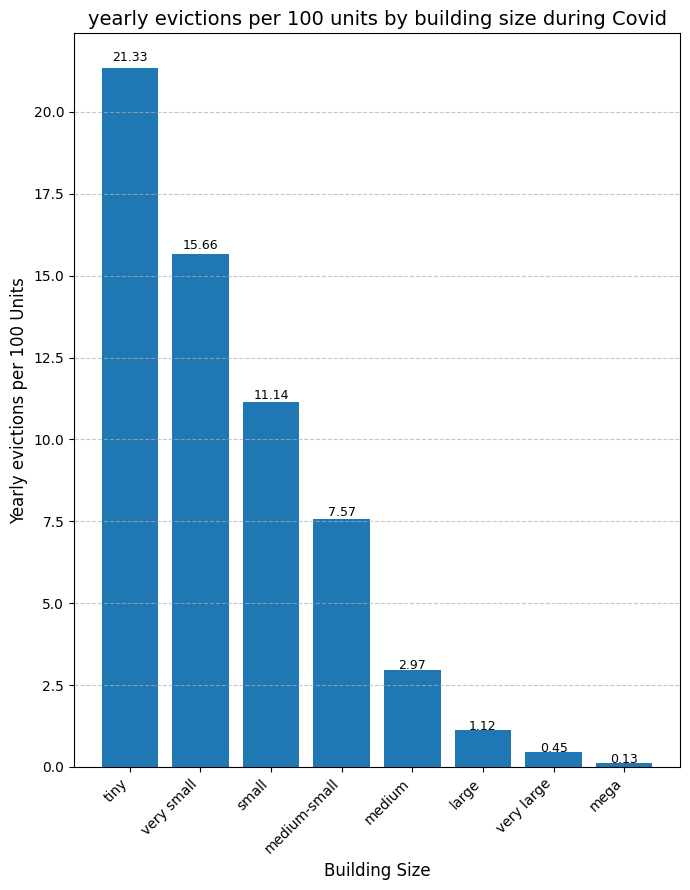

In [88]:
create_bar_chart(
    category_data,
    figsize=(7, 9),
    category_name ='building_size_category',
    rate ='yearly_evictions_per_100unit',
    title='yearly evictions per 100 units by building size during Covid',
    xlabel='Building Size',
    ylabel='Yearly evictions per 100 Units',
    percentage_column=None
)

In [89]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['building_size_category']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. tiny: 21.3333
2. very small: 15.6610
3. small: 11.1353
4. medium-small: 7.5716
5. medium: 2.9650
6. large: 1.1188
7. very large: 0.4472
8. mega: 0.1281


Similar results with the normal times.

In summary, the results during covid were very similar to normal times, indicating the type of landlord/buildings that conducted evictions were no different from the types during normal times.

The factors that have the strongest (inverse) correlation are building size and building height. The taller and larger the buildings, the lower the eviction rate per unit per building. Whereas the age of the building has minimal correlation with the eviction rates, but it might give you some indicator of which types of building have higher eviction rates